In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

# 1. Import Libraries 

In [2]:
# Import necessary libraries
import cv2  # OpenCV for image processing
import numpy as np  # NumPy for array operations
import matplotlib.pyplot as plt  # For plotting images
from PIL import Image  # For opening and converting images
from ultralytics import YOLO  # For loading and using the YOLO model

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 2. Load YOLO Model 

In [3]:
# Load the trained YOLO segmentation model
model = YOLO("/kaggle/input/seg/other/default/1/best.pt")

# 3. Load and Preprocess Input Image 

In [4]:
# Define the path to the MRI image you want to test
image_path = "/kaggle/input/brain-tumor-dataset-for-instance-seg-yolo-11/test/images/Tr-gl_0038_jpg.rf.59d915a51e1e15ada3f66021f428d91f.jpg"

# Open the image using PIL and convert it to RGB format
image = Image.open(image_path).convert("RGB")

# Convert image to NumPy array
img_np = np.array(image)

# Convert RGB image to BGR (OpenCV uses BGR format)
img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Get image height and width to calculate total brain area
h, w = img_bgr.shape[:2]
brain_area = h * w

# 4.  Show Original MRI Image 

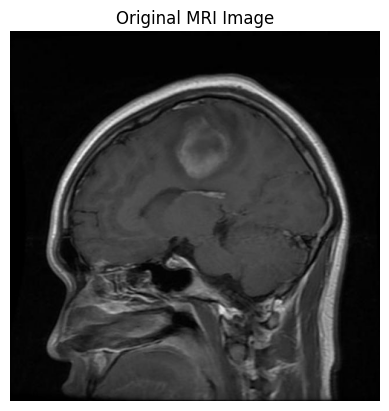

In [5]:
# Display the original MRI image using matplotlib
plt.imshow(img_np)
plt.title("Original MRI Image")
plt.axis("off")
plt.show()

# 5. Run YOLO Prediction 

In [6]:
# imgsz=640 sets the input size, conf=0.25 sets the confidence threshold
results = model.predict(source=img_np, imgsz=640, conf=0.25)


0: 640x640 1 Glioma, 20.2ms
Speed: 10.5ms preprocess, 20.2ms inference, 336.6ms postprocess per image at shape (1, 3, 640, 640)


# 6. Display Bounding Boxes 

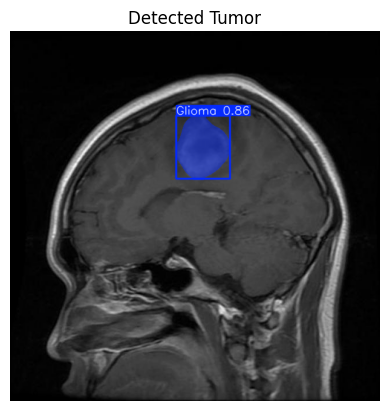

In [7]:
# Get the first result (only one image here)
r = results[0]

# Plot the image with bounding boxes and masks (if any)
annotated_img = r.plot()

# Convert BGR to RGB for displaying with matplotlib
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Tumor")
plt.axis("off")
plt.show()

# 7. Process Segmentation Masks 

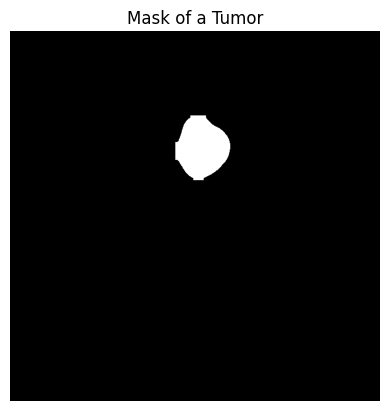

In [9]:
# Check if any masks were detected by YOLO
if r.masks is None:
    print("⚠️ No tumor detected.")
else:
    # Create a copy of the original image to draw masks on
    overlay = img_bgr.copy()
    
    # Get masks and bounding boxes
    masks = r.masks.data.cpu().numpy()  # Convert to NumPy array
    boxes = r.boxes  # Get bounding boxes

    # Loop through each detected mask and bounding box
    for i, (mask, box) in enumerate(zip(masks, boxes)):
        # Convert mask to binary (0 or 255)
        mask_bin = (mask * 255).astype(np.uint8)

        # Find contours from the binary mask
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            continue  # Skip if no contours found

        # Find the largest contour (main tumor area)
        largest_contour = max(contours, key=cv2.contourArea)

        # Calculate tumor area in pixels
        tumor_area = cv2.contourArea(largest_contour)

        # Draw contour on the overlay image
        cv2.drawContours(overlay, [largest_contour], -1, (0, 0, 255), 2)  # Red color

        # Get class label from box
        class_id = int(box.cls[0])  # Get class ID
        label = model.names[class_id] if hasattr(model, "names") else f"Class {class_id}"

        # Calculate percentage of brain affected
        tumor_percent = (tumor_area / brain_area) * 100 if brain_area > 0 else 0

        # Prepare text label with tumor class and size
        label_text = f"{label.capitalize()} | {tumor_percent:.2f}%"

        # Get a point to place the label (starting point of contour)
        x, y = largest_contour[0][0]

        # Draw label text on the overlay
        cv2.putText(overlay, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 0, 255), 2)

        # Show the mask alone in grayscale
        plt.imshow(mask_bin, cmap='gray')
        plt.title("Mask of a Tumor")
        plt.axis('off')
        plt.show()

# 8. Show Final Annotated Image 

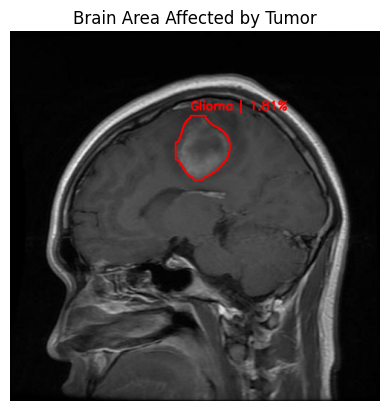

In [10]:
# Convert final overlay from BGR to RGB for plotting
final_image = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Show the final image with tumor mask and area label
plt.imshow(final_image)
plt.title("Brain Area Affected by Tumor")
plt.axis("off")
plt.show()